In [1]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA # Principal component analysis
import torch # Neural network training and inference
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numpy.linalg import eig
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import patsy
from matplotlib.colors import ListedColormap, BoundaryNorm

# Parameters which AI Poincare and PullNN classes are using for inference
PREPROCESS_EIGENVALUE_THRESHOLD = 0.001 # Threshold for linear invariant
PULLNN_HIDDEN_LAYERS = [256,256] # Pull NN hidden layers
PULLNN_LEAKYRELU_SLOPE = 0 # Slope for the Leaky Rectified Linear Unit
PULLNN_OPTIMIZER_TYPE = 'Adam' # Either Adam or SGD
PULLNN_LEARNING_RATE = 0.001 # Learning rate for optimization
PULLNN_BATCH_SIZE = 1024 # Batch size for training
PULLNN_TRAIN_ITER = 500 # Number of training iterations
PULLNN_TRAIN_LOGITER = 200 # Log after every given number of iterations
NEFF_NPOINTS = 100 # Number of starting points for estimating Neff
NEFF_WALK_STEPS = 2000 # Number of random walk steps to estimate Neff
NEFF_FORMULA_A = 2

In [2]:
def henon_heiles(t, y, lmbda):
    x, y, px, py = y
    
    # Equations of motion
    dxdt = px
    dydt = py
    dpxdt = -x - 2 * lmbda * x * y
    dpydt = -y - lmbda * (x**2 - y**2)
    
    return np.array([dxdt, dydt, dpxdt, dpydt])

def runge_kutta_45_henon_heiles(t0, y0, h, T, lmbda):
    t_values = [t0]
    y_values = [y0]

    num_steps = int((T - t0) / h)

    for _ in range(num_steps):
        t = t_values[-1]
        y = y_values[-1]

        k1 = h * henon_heiles(t, y, lmbda)
        k2 = h * henon_heiles(t + 1/4 * h, y + 1/4 * k1, lmbda)
        k3 = h * henon_heiles(t + 3/8 * h, y + 3/32 * k1 + 9/32 * k2, lmbda)
        k4 = h * henon_heiles(t + 12/13 * h, y + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3, lmbda)
        k5 = h * henon_heiles(t + h, y + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4, lmbda)
        k6 = h * henon_heiles(t + 1/2 * h, y - 8/27 * k1 + 2 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5, lmbda)

        y_new = y + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5

        t_values.append(t + h)
        y_values.append(y_new)

    return np.array(t_values), np.array(y_values)

In [3]:
# Set parameters
t0 = 0
#y0 = np.array([0, 0.62, 0.1232, 0])  # Initial conditions [x, y, px, py]

y0 = np.array([0, 0.5, 0.1232, 0])

h = 0.1  # Step size
T = 300  # End time
lmbda = 1.0  # Parameter

# Run the Runge-Kutta 4(5) method for the Hénon-Heiles system
t_values, y_values = runge_kutta_45_henon_heiles(t0, y0, h, T, lmbda)

# Extract individual variables for plotting
x_values, y_values, px_values, py_values = y_values.T

# Calculate x'' using central difference approximation
dxdt_values = np.gradient(x_values, h)  # Central difference to approximate x''
dydt_values = np.gradient(y_values, h)  # Central difference to approximate x''

In [4]:
def get_energy(x,y,xt,yt):
    return (1/2*(x**2+y**2+xt**2+yt**2)+x**2*y-1/3*y**3)
energy = get_energy(x_values,y_values,px_values,py_values)

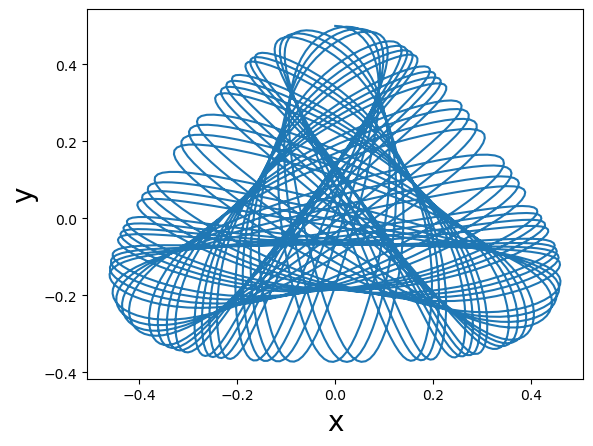

In [5]:
plt.plot(x_values, y_values, label='x')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.savefig('henon_trj.pdf')
plt.show()

In [6]:
dat = []
dat.append(x_values)
dat.append(px_values)
dat.append(y_values)
dat.append(py_values)
data = np.array(dat).T

In [7]:
from aipoincare1_lib import AIPoincare
som = AIPoincare(data)
Larray = np.logspace(0,2.3,10)/100
som.run(Larray)

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


[0.0000000e+00 0.0000000e+00 0.0000000e+00 4.3732986e-02 1.2859055e+00
 1.7824016e+00 1.3897127e+00 2.9371831e-01 1.4933663e-03 0.0000000e+00]


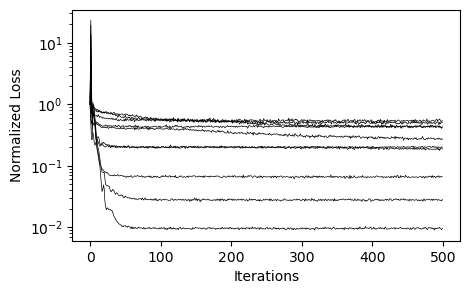

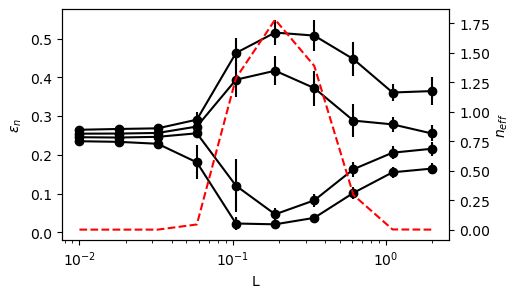

In [8]:
som.plot_mseloss(plt)
som.plot_exp_ratio_diagram(plt)
plt.savefig('henon_exp.pdf')

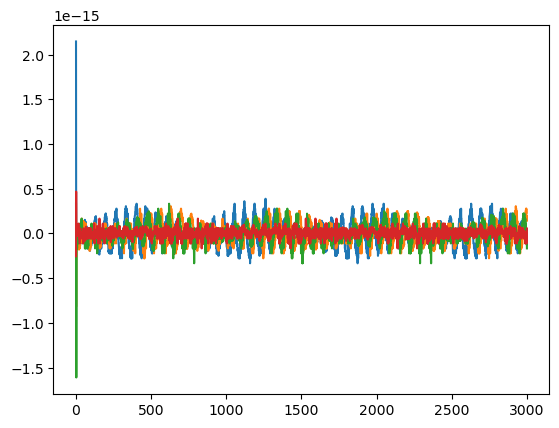

In [9]:
###########################################################################################################################
# Prewhitening part of the algorithm
PREPROCESS_EIGENVALUE_THRESHOLD = 0.001

# Step 1: Normalized trajectory
mean_trajectory_data = np.mean(data, axis=0)
std_trajectory_data = np.std(data, axis=0)
trajectory_data_normalized0 = (data -
                mean_trajectory_data[np.newaxis,:])\
                        /std_trajectory_data

# Step 2: Principal Component Analysis to extract linear invariants
pca = PCA() # Get the PCA object
transformed_data = pca.fit_transform(trajectory_data_normalized0)
eigs_above_threshold = np.sum(pca.explained_variance_ratio_
                    > PREPROCESS_EIGENVALUE_THRESHOLD)
data1 = transformed_data[:,:eigs_above_threshold]
std_data = np.std(transformed_data,axis=0)
change_of_basis = pca.components_
inverse = np.linalg.inv(change_of_basis)


# Step 3: Scaling again for isotropy
trajectory_data_normalized = transformed_data/(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
###########################################################################################################################
# From transformed data to raw data
data_before_final_scaling = trajectory_data_normalized*(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
data_before_pca = np.matmul(inverse,data_before_final_scaling.T).T
data_before_transformations = data_before_pca*std_trajectory_data+mean_trajectory_data[np.newaxis,:]

w = trajectory_data_normalized*(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
ww = np.matmul(inverse,w.T).T
www = ww*(std_trajectory_data)+mean_trajectory_data[np.newaxis,:]

must_be_zero = data_before_transformations-data
dim0 = must_be_zero.shape[0]
dim1 = must_be_zero.shape[1]
x_axis = np.zeros(dim0)
plt.plot(must_be_zero)

In [10]:
nnwidths = som.nn_widths # Neural network architecture
ndims = som.ndim # Number of dimensions
npts = som.npts # Number of points in the data
inf = som.nn_state_dict_list # Some information of trained neural network
dt = 1
range_of_jj = int(dim0/dt)

from aipoincare1_lib import PullNN

pullnn = PullNN(nnwidths) # Set up a fresh network
pullnn.load_state_dict(inf[5])

<All keys matched successfully>

In [11]:
eigenvalues = []

svss = []

for jj in range(len(data)): # Iterate to choose random points
    
    ########################################################################################################################
    perturb = torch.normal(0, Larray[3], size = (NEFF_WALK_STEPS,
        dim1), dtype=torch.float)
    # Create a bunch of points in the neighborhood
    x0 = torch.tensor(trajectory_data_normalized[jj], dtype=torch.float) + perturb
    # Try to walk all the points back to the manifold and convert the
    # torch tensor to numpy matrix data where required.
    # The Pull Network calculates the distance to the closest point in the
    # manifold. So to get back to the manifold we need to add x0. This is
    # different from how the paper is phrased. Not sure why this helps.
    pull_back = pullnn(x0).detach() # Detach from the network
    # Pull back all points to the local tangent plane.
    x0 = x0 + pull_back
    x1 = x0.tolist()
    
    #Convert data to nonscaled case for checking the invariants
    # 1)scaling, 2)pca, 3)scaling again
    # Have to go back from where we began
    #x11 = np.array(x1)*(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
    #x12 = np.matmul(inverse,x11.T).T
    #x2 = x12*(std_trajectory_data)+mean_trajectory_data[np.newaxis,:]
    
    # Step 3: Find the dimensionality of the local set of points
    pca = PCA() # Declare a Principal Component Analysis object
    pca.fit(x1) # Try to fit to the trajectory data
    svs = pca.singular_values_ # Get the eigenvalues
    #neff = []
    svss.append(svs**2/np.sum(svs**2))
    #for i in range(len(svss)):
    #    if svss[i]>0.001:
    #        neff.append(svss[i])
    ########################################################################################################################
    
    if jj%1000==0:
        print(jj)
    
eigs = np.array(eigenvalues)
lambdas = np.mean(eigs,axis=0)

0
1000
2000
3000


C:\Users\User\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
eggs = np.array(svss)

In [13]:
final = []
for i in range(len(eggs)):
    eigsabove = []
    for j in range(len(eggs[0])):
        if eggs[i][j]<0.014:
            eigsabove.append(eggs[i][j])
    length = len(eigsabove)
    final.append(length)
neff = np.array(final)

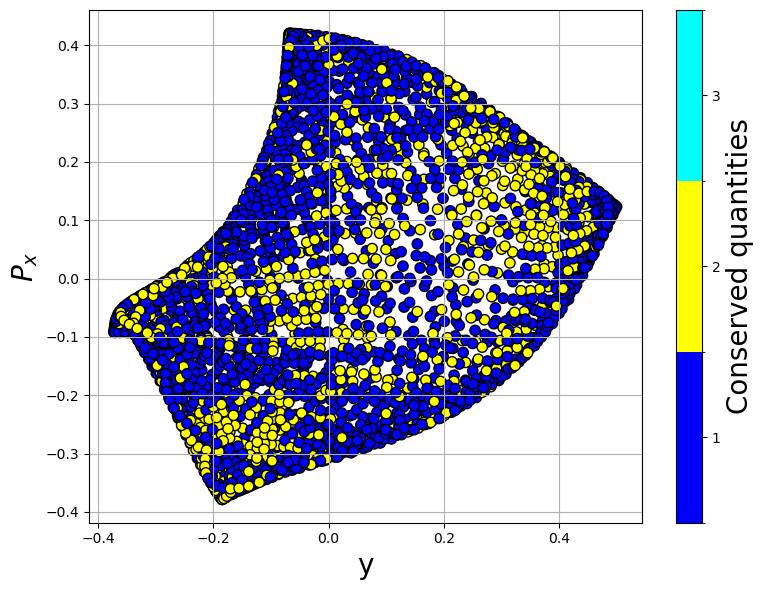

In [14]:
# Define custom colors for each value of y
colors = [ 'blue', 'yellow', 'cyan']
cmap = ListedColormap(colors)

boundaries = [0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

plt.figure(figsize=(8, 6))
sc = plt.scatter(y_values, px_values, c=neff, cmap=cmap, edgecolors='k',s=55, norm=norm)
cbar=plt.colorbar(sc, ticks=[1, 2, 3, 4], label='Conserved quantities')
cbar.ax.yaxis.label.set_fontsize(20)
# Plot the predicted surface
plt.xlabel('y', fontsize=20)
plt.ylabel(r'$P_x$', fontsize=20)
#plt.title('Local dimensionality')
plt.grid(True)
#plt.legend()
plt.tight_layout()

plt.savefig('ps_y_Px.pdf')

plt.show()

In [15]:
reg_x=[]
reg_px=[]
for i in range(len(neff)):
    if neff[i]>1:
        reg_x.append(x_values[i])
        reg_px.append(px_values[i])
region_xd = np.array(reg_x)  
region_pxd = np.array(reg_px) 

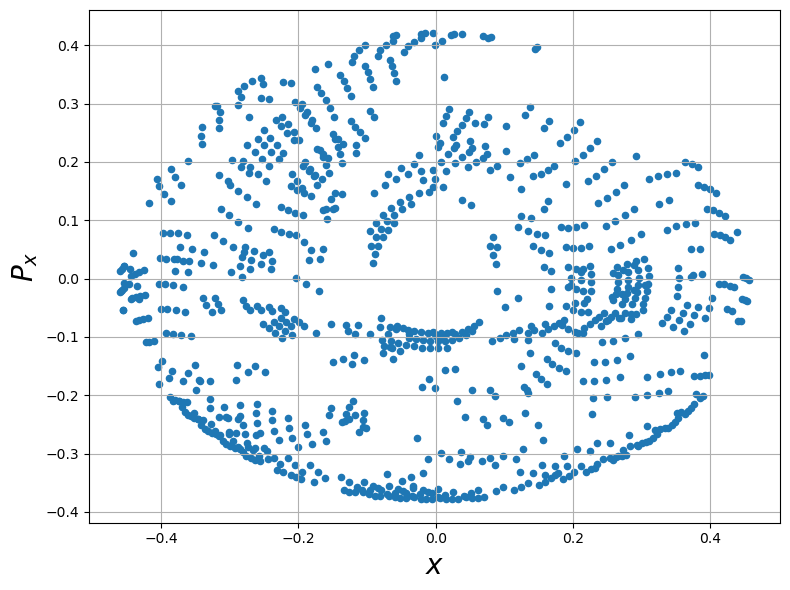

In [16]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(region_xd, region_pxd, s=20)

plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$P_x$', fontsize=20)
plt.grid(True)
#plt.legend()
plt.tight_layout()
plt.savefig('int_x_px.pdf')
plt.show()